In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt

Reading and observing the dataset at hand

In [2]:
ls

house prices.csv  reduction.ipynb


In [3]:
df = pd.read_csv('house prices.csv')
df.drop('Id', inplace=True, axis=1)

In [4]:
df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [6]:
def show_nans():
    nan_df = pd.DataFrame(df.isna().sum(axis=0), columns=['nan-count'])
    nan_df = nan_df.sort_values('nan-count', ascending=False)
    return nan_df

Removing Nan values if possible and replacing them with the Nan values defined specifically for each

In [7]:
df['PoolQC'].fillna('NA', inplace=True)
df['MiscFeature'].fillna('NA', inplace=True)
df['Alley'].fillna('NA', inplace=True)
df['Fence'].fillna('NA', inplace=True)
df['FireplaceQu'].fillna('NA', inplace=True)
df['GarageCond'].fillna('NA', inplace=True)
df['GarageFinish'].fillna('NA', inplace=True)
df['GarageQual'].fillna('NA', inplace=True)
df['GarageType'].fillna('NA', inplace=True)
df['BsmtFinType2'].fillna('NA', inplace=True)
df['BsmtFinType1'].fillna('NA', inplace=True)
df['BsmtExposure'].fillna('NA', inplace=True)
df['BsmtCond'].fillna('NA', inplace=True)
df['BsmtQual'].fillna('NA', inplace=True)
df['LotFrontage'].fillna(df['LotFrontage'].mean(), inplace=True) # should be experimented
show_nans()

,nan-count
GarageYrBlt,81
MasVnrType,8
MasVnrArea,8
Electrical,1
KitchenQual,0
...,...
ExterCond,0
ExterQual,0
Exterior2nd,0
Exterior1st,0


In [8]:
df.drop('GarageYrBlt', axis=1, inplace=True)

In [9]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [10]:
df.shape

(1451, 79)

In [11]:
number_df = df.select_dtypes('number')
object_df = df.select_dtypes('object')

In [12]:
number_df.shape, object_df.shape

((1451, 36), (1451, 43))

In [13]:
object_df.head(3)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
1,RL,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
2,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal


In [14]:
number_df.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500


In [15]:
for column in object_df.columns:
    object_df[column] = pd.factorize(object_df[column])[0]

<ipython-input-15-57231cb53607>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  object_df[column] = pd.factorize(object_df[column])[0]


In [16]:
df = pd.concat([number_df, object_df], axis=1)

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

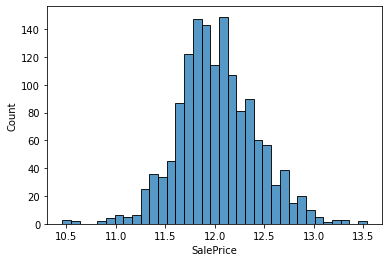

In [17]:
sns.histplot(np.log(df['SalePrice']))

In [18]:
def scaler_features(df, log_target=False):
    df_copy = df.copy()
    df_copy_target = df_copy.pop('SalePrice')
    if log_target:
        df_copy_target = np.log1p(df_copy_target)
    df_copy_target.reset_index(drop=True, inplace=True)
    scaler = MinMaxScaler()
    df_copy = pd.DataFrame(scaler.fit_transform(df_copy), columns=df_copy.columns)
    df_copy = pd.concat([df_copy, df_copy_target], axis=1)
    return df_copy

### First Part

<AxesSubplot:>

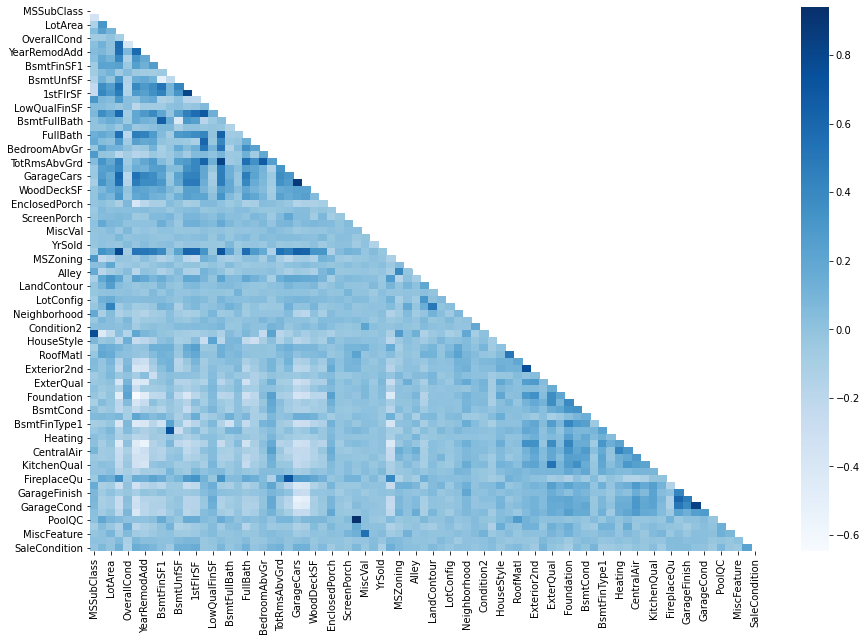

In [19]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), mask=np.triu(df.corr()), cmap='Blues')

In [20]:
d = scaler_features(df, log_target=True)

In [21]:
y_df = d.pop('SalePrice')
X_df = d

In [22]:
X_df

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.122500,0.125089,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.000000,0.173281,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.101250,0.086109,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.000000,0.038271,0.000000,...,0.166667,0.333333,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.2
4,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.218750,0.116052,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,0.235294,0.140411,0.030929,0.555556,0.500,0.920290,0.833333,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
1447,0.000000,0.219178,0.055505,0.555556,0.625,0.768116,0.633333,0.074375,0.139972,0.110583,...,0.000000,0.333333,0.0,0.0,0.0,0.0,0.25,0.00,0.0,0.0
1448,0.294118,0.154110,0.036187,0.666667,1.000,0.500000,0.933333,0.000000,0.048724,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.75,0.25,0.0,0.0
1449,0.000000,0.160959,0.039342,0.444444,0.625,0.565217,0.766667,0.000000,0.008682,0.698100,...,0.000000,0.333333,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0


In [23]:
y_df

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1446    12.072547
1447    12.254868
1448    12.493133
1449    11.864469
1450    11.901590
Name: SalePrice, Length: 1451, dtype: float64

Linear regression model

In [24]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_df, y_df)

LinearRegression()

In [25]:
intercept = regressor.intercept_
features = pd.DataFrame(regressor.coef_, X_df.columns, columns=['coefficient'])
features.sort_values('coefficient', ascending=False).head()

,coefficient
BsmtFinSF1,4.548913e+12
1stFlrSF,3.475287e+12
BsmtUnfSF,1.882753e+12
2ndFlrSF,1.646734e+12
BsmtFinSF2,1.188005e+12


In [26]:
features.coefficient = features.coefficient.abs()
stdevs = []
for i in X_df.columns:
    stdev = d[i].std()
    stdevs.append(stdev)

features["stdev"] = np.array(stdevs).reshape(-1,1)
features["importance"] = features["coefficient"] * features["stdev"]

In [27]:
features['importance_normalized'] = 100*features['importance'] / features['importance'].max()

In [28]:
features = features.sort_values('importance_normalized', ascending=False).head(10)

<BarContainer object of 10 artists>

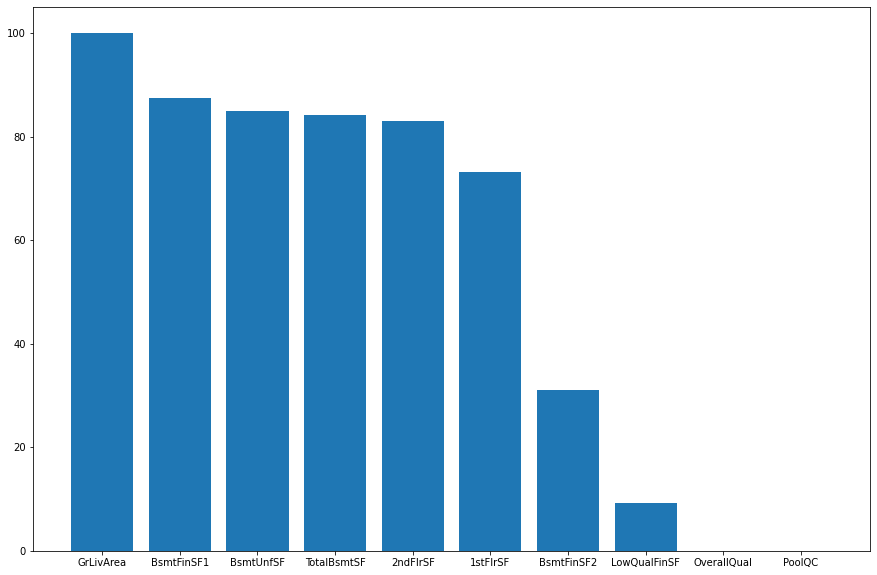

In [29]:
plt.figure(figsize=(15, 10))
plt.bar(features.index, features.importance_normalized)

Decision Tree model

In [30]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth=5)
dtr.fit(X_df, y_df)

DecisionTreeRegressor(max_depth=5)

In [31]:
feature_importance = pd.Series(dtr.tree_.compute_feature_importances(), index=X_df.columns)

In [32]:
feature_importance = feature_importance.sort_values(ascending=False).head(10)

<BarContainer object of 10 artists>

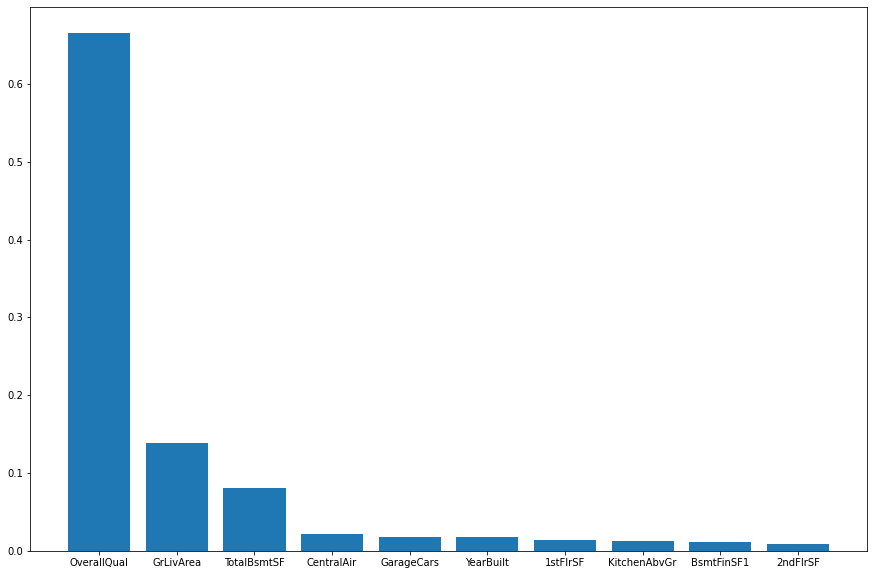

In [33]:
plt.figure(figsize=(15, 10))
plt.bar(feature_importance.index, feature_importance.values)

---

Backward Elimination

In [34]:
bias = pd.Series(np.ones(X_df.shape[0]), name='bias')
pd.concat([X_df, bias], axis=1)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,bias
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.122500,0.125089,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,1.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.000000,0.173281,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,1.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.101250,0.086109,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,1.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.000000,0.038271,0.000000,...,0.333333,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.2,1.0
4,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.218750,0.116052,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,0.235294,0.140411,0.030929,0.555556,0.500,0.920290,0.833333,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,1.0
1447,0.000000,0.219178,0.055505,0.555556,0.625,0.768116,0.633333,0.074375,0.139972,0.110583,...,0.333333,0.0,0.0,0.0,0.0,0.25,0.00,0.0,0.0,1.0
1448,0.294118,0.154110,0.036187,0.666667,1.000,0.500000,0.933333,0.000000,0.048724,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.75,0.25,0.0,0.0,1.0
1449,0.000000,0.160959,0.039342,0.444444,0.625,0.565217,0.766667,0.000000,0.008682,0.698100,...,0.333333,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,1.0


In [35]:
import statsmodels.api as sm

In [36]:
model = sm.OLS(y_df, X_df)
results = model.fit()

In [37]:
p_value_threshold = 0.05
non_useful_features = []
for i in range(len(results.pvalues)):
    if results.pvalues[i] > p_value_threshold:
        non_useful_features.append(results.pvalues.index[i])

### Model

In [38]:
def to_dataloader(df, target_col, batch_size):
    target = torch.tensor(df[target_col].values.astype(np.float32))
    data = torch.tensor(df.drop(target_col, axis=1).values.astype(np.float32))

    data_tensor = torch.utils.data.TensorDataset(data, target)
    data_loader = DataLoader(data_tensor, shuffle=True, batch_size=batch_size)
    return data_loader

Definition of the model

In [39]:
class Regressor_nn(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, output_size, activation_function):
        super(Regressor_nn, self).__init__()
        self.activation_function = activation_function
        self.fcs = nn.ModuleList()
        self.n_layers = n_layers
        self.fcs.append(nn.Linear(input_size, hidden_size[0]))
        for i in range(n_layers - 1):
            self.fcs.append(nn.Linear(hidden_size[i], hidden_size[i + 1]))
        self.fcs.append(nn.Linear(hidden_size[-1], output_size))
    def forward(self, x):
        for i in range(n_layers):
            x = self.activation_function(self.fcs[i](x))
        x = self.fcs[-1](x)
        x = x.squeeze(1)
        return x

In [40]:
def train(model, train_loader, test_loader, criterion_mse, criterion_mae, optimizer):
    epochs_loss_mse = []
    epochs_loss_mae = []
    epochs_loss_mse_test = []
    epochs_loss_mae_test = []
    for epoch in tqdm(range(n_epochs), leave=False):
        batchs_loss_mse = []
        batchs_loss_mae = []
        for batch_idx, (data, targets) in enumerate(train_loader):
            outputs = model(data)
            mse = criterion_mse(outputs, targets)
            optimizer.zero_grad()
            mse.backward()
            optimizer.step()
            
            with torch.no_grad():
                mae = criterion_mae(outputs, targets)
            batchs_loss_mse.append(mse.item())
            batchs_loss_mae.append(mae.item())
        
        epochs_loss_mse.append(np.mean(batchs_loss_mse))
        epochs_loss_mae.append(np.mean(batchs_loss_mae))
        batchs_loss_mse_test, batchs_loss_mae_test, _, _ = check_accuracy(model, test_loader, criterion_mse, criterion_mae)
        epochs_loss_mse_test.append(batchs_loss_mse_test)
        epochs_loss_mae_test.append(batchs_loss_mae_test)
    return epochs_loss_mse, epochs_loss_mae, epochs_loss_mse_test, epochs_loss_mae_test

In [41]:
def check_accuracy(model, loader, criterion_mse, criterion_mae):
    model.eval()
    outputs_agg = np.array([])
    targets_agg = np.array([])
    with torch.no_grad():
        batchs_loss_mse = []
        batchs_loss_mae = []
        for batch_idx, (data, targets) in enumerate(loader):
            outputs = model(data)
            outputs_agg = np.append(outputs_agg, outputs.numpy())
            targets_agg = np.append(targets_agg, targets.numpy())
            mse = criterion_mse(outputs, targets)
            mae = criterion_mae(outputs, targets)
            batchs_loss_mse.append(mse.item())     
            batchs_loss_mae.append(mae.item())
    print('mse error :{}, mae error :{}'.format(mse.item(), mae.item()))
    model.train()
    return np.mean(batchs_loss_mse), np.mean(batchs_loss_mae), outputs_agg, targets_agg

In [42]:
def plot_losses(epochs_loss_mse, epochs_loss_mae, epochs_loss_mse_test, epochs_loss_mae_test, title):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(title)
    sns.lineplot(data=epochs_loss_mse, label='train data', ax=axs[0])
    sns.lineplot(data=epochs_loss_mse_test, label='test data', ax=axs[0])
    axs[0].grid()
    axs[0].set_title('MSE loss per epoch')
    sns.lineplot(data=epochs_loss_mae, label='train data', ax=axs[1])
    sns.lineplot(data=epochs_loss_mae_test, label='test data', ax=axs[1])
    axs[1].grid()
    axs[1].set_title('MAE loss per epoch')
    plt.tight_layout()

In [43]:
def plot_predictions(outputs_agg, targets_agg):
    fig = plt.figure(figsize=(10, 10))
    sns.scatterplot(y=outputs_agg, x=targets_agg)
    plt.ylabel('predictions')
    plt.xlabel('targets')
    plt.ylim((np.min(targets_agg), np.max(targets_agg)))

In [44]:
batch_size = 64
dff = scaler_features(df, log_target=True)
train_df = dff.sample(frac=.8, random_state=707)
test_df = dff.drop(train_df.index)

train_loader = to_dataloader(
    df=train_df, 
    target_col='SalePrice', 
    batch_size=batch_size
)
test_loader = to_dataloader(
    df=test_df, 
    target_col='SalePrice', 
    batch_size=batch_size
)

In [45]:
input_size = dff.shape[1] - 1
n_layers = 4
hidden_size = [100, 64, 32, 16]
activation_function = F.relu
output_size = 1
lr = 0.001
n_epochs = 100

  0%|          | 0/100 [00:00<?, ?it/s]

mse error :143.96974182128906, mae error :11.993995666503906
mse error :110.47576904296875, mae error :10.505082130432129
mse error :4.041144847869873, mae error :1.5706779956817627
mse error :5.2842698097229, mae error :2.0145790576934814
mse error :2.3873982429504395, mae error :1.165777325630188
mse error :2.2853429317474365, mae error :1.2569663524627686
mse error :2.974802255630493, mae error :1.4928579330444336
mse error :2.0135304927825928, mae error :1.1728224754333496
mse error :2.0216925144195557, mae error :1.170329213142395
mse error :1.0310218334197998, mae error :0.7906638979911804
mse error :1.7919085025787354, mae error :1.1392053365707397
mse error :1.586758017539978, mae error :1.050403118133545
mse error :0.7748236656188965, mae error :0.7016136050224304
mse error :1.1444251537322998, mae error :0.9262864589691162
mse error :0.9020156860351562, mae error :0.7923935055732727
mse error :0.9266918897628784, mae error :0.7853678464889526
mse error :0.91509610414505, mae 

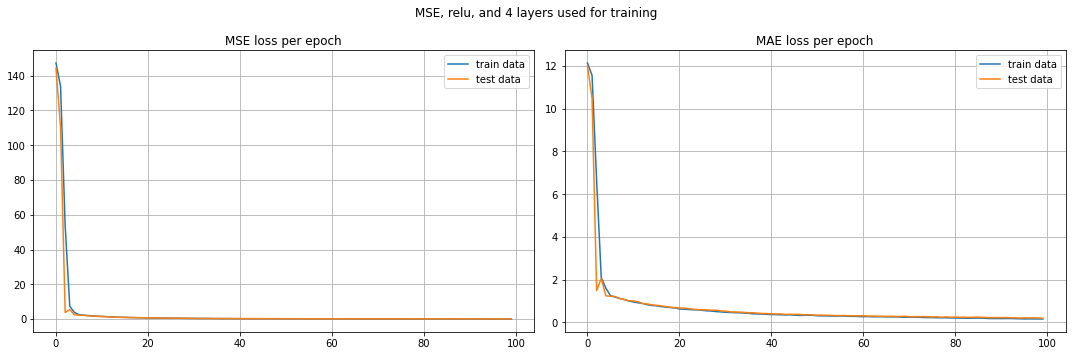

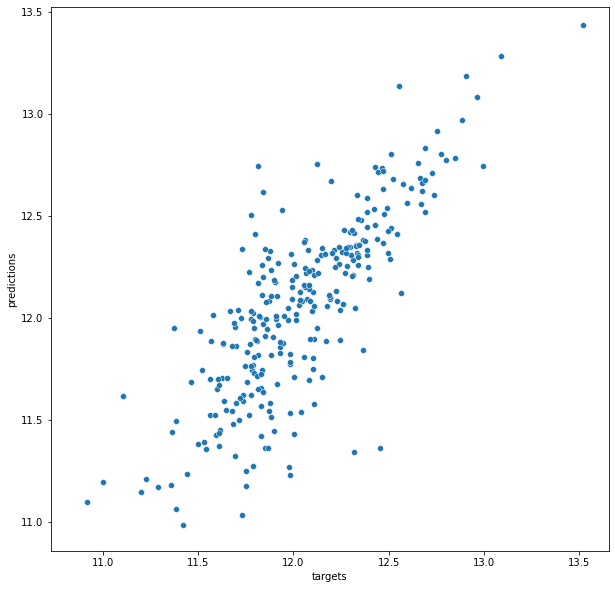

In [46]:
model = Regressor_nn(
    input_size=input_size, 
    hidden_size=hidden_size, 
    n_layers=n_layers, 
    output_size=output_size, 
    activation_function=activation_function
)

criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr)
epochs_loss_mse, epochs_loss_mae, epochs_loss_mse_test, epochs_loss_mae_test = train(
    model, 
    train_loader,
    test_loader,
    criterion_mse,
    criterion_mae,
    optimizer
)
plot_losses(
    epochs_loss_mse, 
    epochs_loss_mae,
    epochs_loss_mse_test,
    epochs_loss_mae_test,
    'MSE, {}, and {} layers used for training'.format(str(activation_function).split()[1], str(len(hidden_size)))
)
_, _, outputs_agg, targets_agg = check_accuracy(model, test_loader, criterion_mse, criterion_mae)
plot_predictions(outputs_agg, targets_agg)

In [47]:
batch_size = 64
dff = df.drop(non_useful_features, axis=1)
dff = scaler_features(dff, log_target=True)
train_df = dff.sample(frac=.8, random_state=707)
test_df = dff.drop(train_df.index)

train_loader = to_dataloader(
    df=train_df, 
    target_col='SalePrice', 
    batch_size=batch_size
)
test_loader = to_dataloader(
    df=test_df, 
    target_col='SalePrice', 
    batch_size=batch_size
)

In [48]:
input_size = dff.shape[1] - 1
n_layers = 4
hidden_size = [100, 64, 32, 16]
activation_function = F.relu
output_size = 1
lr = 0.001
n_epochs = 100

  0%|          | 0/100 [00:00<?, ?it/s]

mse error :144.44674682617188, mae error :12.012250900268555
mse error :119.34840393066406, mae error :10.919580459594727
mse error :14.397534370422363, mae error :3.665106773376465
mse error :1.677659034729004, mae error :1.0894759893417358
mse error :1.4098007678985596, mae error :0.9961763024330139
mse error :1.344450831413269, mae error :1.0163429975509644
mse error :1.435252070426941, mae error :1.0025639533996582
mse error :0.8071016073226929, mae error :0.7421635389328003
mse error :1.4793105125427246, mae error :1.0492124557495117
mse error :1.3668804168701172, mae error :0.9605059027671814
mse error :0.5436859726905823, mae error :0.5965992212295532
mse error :1.1247023344039917, mae error :0.8709360957145691
mse error :0.6389704346656799, mae error :0.6550888419151306
mse error :0.649823009967804, mae error :0.6668301820755005
mse error :0.7877792119979858, mae error :0.7294629216194153
mse error :1.1856838464736938, mae error :0.904559314250946
mse error :0.586775004863739, 

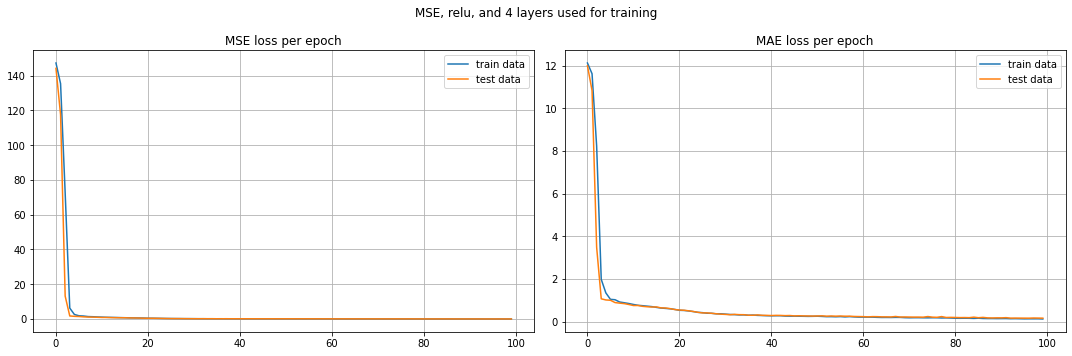

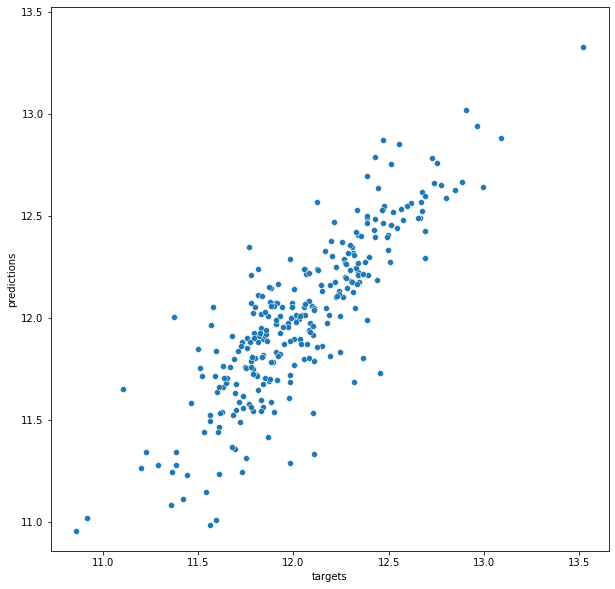

In [49]:
model = Regressor_nn(
    input_size=input_size, 
    hidden_size=hidden_size, 
    n_layers=n_layers, 
    output_size=output_size, 
    activation_function=activation_function
)

criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr)
epochs_loss_mse, epochs_loss_mae, epochs_loss_mse_test, epochs_loss_mae_test = train(
    model, 
    train_loader,
    test_loader,
    criterion_mse,
    criterion_mae,
    optimizer
)
plot_losses(
    epochs_loss_mse, 
    epochs_loss_mae,
    epochs_loss_mse_test,
    epochs_loss_mae_test,
    'MSE, {}, and {} layers used for training'.format(str(activation_function).split()[1], str(len(hidden_size)))
)
_, _, outputs_agg, targets_agg = check_accuracy(model, test_loader, criterion_mse, criterion_mae)
plot_predictions(outputs_agg, targets_agg)